This notebook is mainly reproduce the time-series analysis in the wot [tutorials](https://broadinstitute.github.io/wot/tutorial/). 

Installation:

Pip installation

Note that due to a limitation of pip, cython and numpy need to be installed prior to installing wot using the command:
`pip install numpy cython`
You can then install wot with:
`pip install wot`

Anaconda installation

Install pot dependency:
`conda install -c conda-forge pot`
Install wot (and additional dependencies):
`pip install wot`

In [1]:
# !pip install numpy cython
# !pip install wot
import warnings
warnings.filterwarnings('ignore')

# Visualizing and exploring the data

## Load input data


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import wot
import ipywidgets as widgets

Text(0.5, 1.0, 'Day')

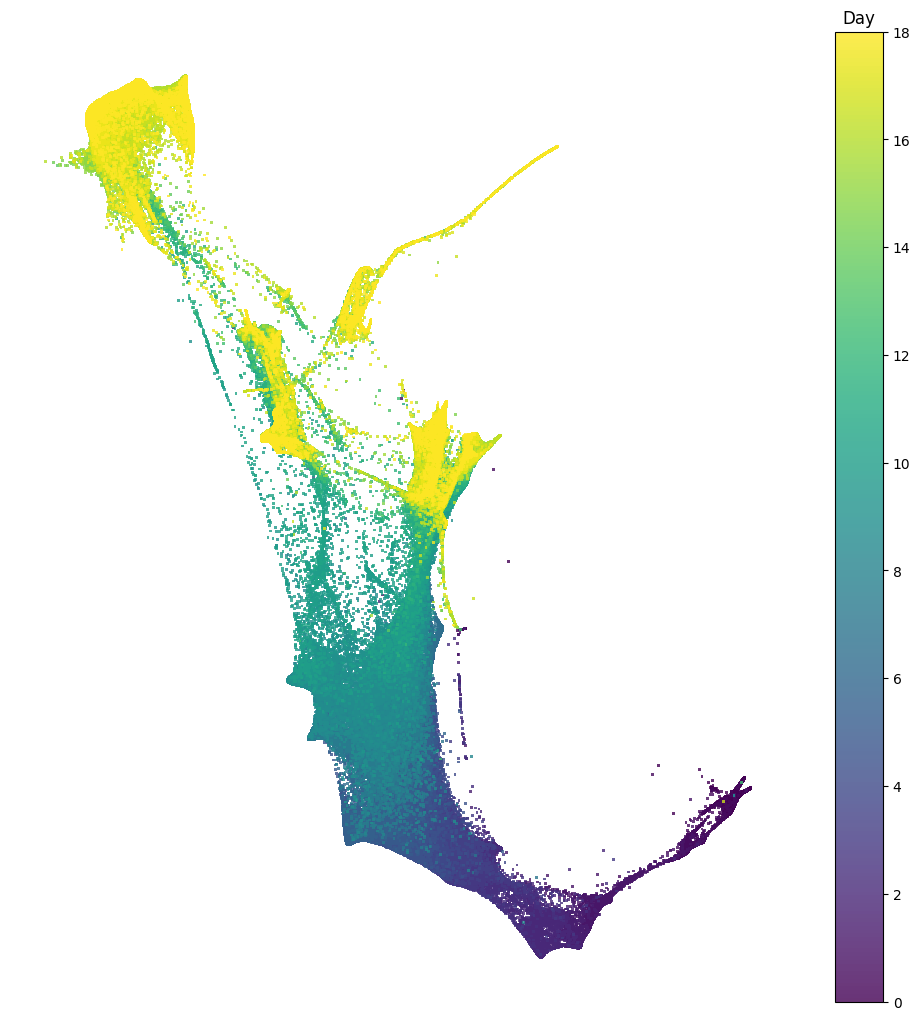

In [3]:
# Path to input files
FLE_COORDS_PATH = '../data/Time_series_scRNA/wot_data/fle_coords.txt'
FULL_DS_PATH = '../data/Time_series_scRNA/wot_data/ExprMatrix.h5ad'
VAR_DS_PATH = '../data/Time_series_scRNA/wot_data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = '../data/Time_series_scRNA/wot_data/cell_days.txt'
GENE_SETS_PATH = '../data/Time_series_scRNA/wot_data/gene_sets.gmx'
GENE_SET_SCORES_PATH = '../data/Time_series_scRNA/wot_data/gene_set_scores.csv'
CELL_SETS_PATH = '../data/Time_series_scRNA/wot_data/cell_sets.gmt'

coord_df = pd.read_csv(FLE_COORDS_PATH, index_col='id', sep='\t')
days_df = pd.read_csv(CELL_DAYS_PATH, index_col='id', sep='\t')

# Read expression matrix, cell days, and 2-d coordinates
adata = wot.io.read_dataset(FULL_DS_PATH, obs=[days_df,coord_df])
unique_days = adata.obs['day'].unique()
unique_days = unique_days[np.isnan(unique_days) == False]
# plot visualization coordinates
figure = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.tight_layout()
plt.scatter(adata.obs['x'], adata.obs['y'],c=adata.obs['day'],
               s=4, marker=',', edgecolors='none', alpha=0.8)
cb = plt.colorbar()
cb.ax.set_title('Day')


In [4]:
from matplotlib import animation
from IPython.display import Video

movie_file_name = 'cells_by_day.gif'
coord_days_df = coord_df.join(days_df)
figure = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.tight_layout()

def animate(i):
    day_df = coord_days_df[coord_days_df['day']==unique_days[i]]
    plt.suptitle('Day {}, {:,} cells'.format(unique_days[i], day_df.shape[0]), y=0.95)
    plt.plot(coord_df['x'], coord_df['y'], ',', color='#f0f0f0', ms=4)
    plt.plot(day_df['x'], day_df['y'], ',', color='black', ms=4)   
    
anim = animation.FuncAnimation(figure, func=animate, frames=range(0, len(unique_days)), init_func=lambda **args:None, repeat=False, interval=400)
writergif = animation.PillowWriter(fps=30)
anim.save(movie_file_name, writer=writergif)
plt.close(figure)
# Video(movie_file_name)


## Compute gene signature scores

In [5]:
gs = wot.io.read_sets(GENE_SETS_PATH, adata.var.index.values)
gene_set_scores_df = pd.DataFrame(index=adata.obs.index)
for j in range(gs.shape[1]):
    gene_set_name = str(gs.var.index.values[j])
    result = wot.score_gene_sets(ds=adata, gs=gs[:, [j]], permutations=0, method='mean_z_score')
    gene_set_scores_df[gene_set_name] = result['score']
gene_set_scores_df.to_csv(GENE_SET_SCORES_PATH, index_label='id')


In [6]:
gene_set_scores_df = pd.read_csv(GENE_SET_SCORES_PATH,index_col='id')
gene_set_dropdown = widgets.Dropdown(
    options=gene_set_scores_df.columns,
    description='Gene Set:'
)

gene_set_scores_df = gene_set_scores_df.join(coord_df).join(days_df)
day_selector = widgets.SelectionRangeSlider(
    options=unique_days,
    continuous_update=False,
    index=(0,len(unique_days)-1),
    description='Days'
)

def update_gene_set_vis(name, days):
    gene_set_score_coords = gene_set_scores_df[(gene_set_scores_df['day']>=days[0]) & (gene_set_scores_df['day']<=days[1])]
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name + ', days {}-{}'.format(days[0], days[1]))
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    plt.scatter(gene_set_score_coords['x'], gene_set_score_coords['y'], c=gene_set_score_coords[name],
                   s=4, marker=',', edgecolors='none')
    cb = plt.colorbar()
    cb.ax.set_title('Signature')
    figure2 = plt.figure(figsize=(10, 5))
    plt.title(name + ', days {}-{}'.format(days[0], days[1]))
    plt.hist(gene_set_score_coords[name])
    return figure, figure2

widgets.interact(update_gene_set_vis, name=gene_set_dropdown, days=day_selector)

interactive(children=(Dropdown(description='Gene Set:', options=('MEF.identity', 'Pluripotency', 'Cell.cycle',…

<function __main__.update_gene_set_vis(name, days)>

In [7]:
# Load cell sets
cell_sets = wot.io.read_sets(CELL_SETS_PATH)

# Visualize Cell Sets 
cell_set_dropdown = widgets.Dropdown(
    options=cell_sets.var.index,
    description='Cell Set:'
)

day_selector = widgets.SelectionRangeSlider(
    options=unique_days,
    continuous_update=False,
    index=(0,len(unique_days)-1),
    description='Days'
)

def update_cell_set_vis(name, days):
    cell_set = cell_sets[:, name]
    cell_set_coords = cell_set[cell_set.X>0].obs.join(coord_df).join(days_df)
    cell_set_coords = cell_set_coords[(cell_set_coords['day']>=days[0]) & (cell_set_coords['day']<=days[1])]
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name + ', days {}-{}, {:,} cells'.format(days[0], days[1], cell_set_coords.shape[0]))
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    plt.scatter(cell_set_coords['x'], cell_set_coords['y'], c=cell_set_coords['day'],
                   s=4, marker=',', edgecolors='none', vmin=unique_days[0],  vmax=unique_days[len(unique_days)-1])
    cb = plt.colorbar()
    cb.ax.set_title('Day')

## Compute force layout embedding coordinates

In [8]:
adata_var = wot.io.read_dataset(VAR_DS_PATH, obs=[days_df])

In [9]:
import scanpy as sc

sc.pp.pca(adata_var, n_comps=2)
sc.pp.neighbors(adata_var)
sc.tl.diffmap(adata_var)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Text(0.5, 1.0, 'Day')

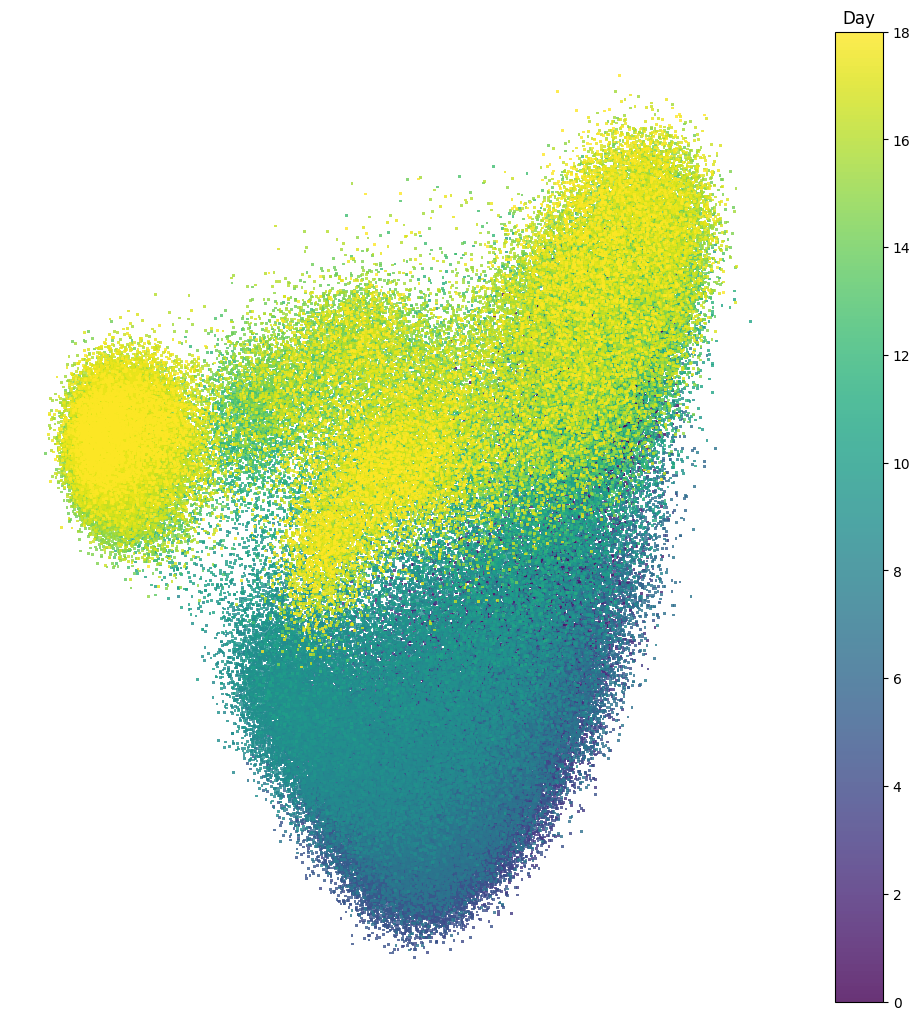

In [10]:
figure = plt.figure(figsize=(10, 10))
plt.axis('off')
plt.tight_layout()
coords = adata_var.obsm['X_pca']
# adata_var.obs = adata_var.obs.join(adata.obs, on='day')
plt.scatter(coords[:, 0], coords[:, 1], c=adata_var.obs['day'], s=4, marker=',', edgecolors='none', alpha=0.8)
cb = plt.colorbar()
cb.ax.set_title('Day')

# Computing transport matrices

## Construct initial estimate of cell growth rates

In [11]:
# load proliferation and apoptosis scores
gene_set_scores = pd.read_csv('../data/Time_series_scRNA/wot_data/gene_set_scores.csv', index_col=0)
proliferation=gene_set_scores['Cell.cycle']
apoptosis = gene_set_scores['Apoptosis']

# apply logistic function to transform to birth rate and death rate
def logistic(x, L, k, x0=0):
    f = L / (1 + np.exp(-k * (x - x0)))
    return f
def gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width):
    return beta_min + logistic(p, L=beta_max - beta_min, k=4 / width, x0=center)

def beta(p, beta_max=1.7, beta_min=0.3, pmax=1.0, pmin=-0.5, center=0.25):
    return gen_logistic(p, beta_max, beta_min, pmax, pmin, center, width=0.5)

def delta(a, delta_max=1.7, delta_min=0.3, amax=0.5, amin=-0.4, center=0.1):
    return gen_logistic(a, delta_max, delta_min, amax, amin, center,
                          width=0.2)

birth = beta(proliferation)
death = delta(apoptosis)

# growth rate is given by 
gr = np.exp(birth-death)
growth_rates_df = pd.DataFrame(index=gene_set_scores.index, data={'cell_growth_rate':gr})
growth_rates_df.to_csv('../data/Time_series_scRNA/wot_data/growth_gs_init.txt')

In [12]:
VAR_GENE_DS_PATH = '../data/Time_series_scRNA/wot_data/ExprMatrix.var.genes.h5ad'
CELL_DAYS_PATH = '../data/Time_series_scRNA/wot_data/cell_days.txt'
SERUM_CELL_IDS_PATH = '../data/Time_series_scRNA/wot_data/serum_cell_ids.txt'
CELL_GROWTH_PATH = '../data/Time_series_scRNA/wot_data/growth_gs_init.txt'

# load data
adata = wot.io.read_dataset(VAR_GENE_DS_PATH, obs=[CELL_DAYS_PATH, CELL_GROWTH_PATH], obs_filter=SERUM_CELL_IDS_PATH)
adata.shape

(175472, 1479)

## The optimization problem

In [13]:
# create OTModel
ot_model = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50) 

In [14]:
# Compute a single transport map from day 7 to 7.5
tmap_annotated = ot_model.compute_transport_map(7,7.5)

In [15]:
# row annotations include cell growth rates
tmap_annotated.obs

# columns annotated by cell barcodes
# tmap_annotated.var

,g0,g1
index,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.268895,0.977572
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.978660,2.510172
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.871918,1.789111
D7_Dox_C1_AAACCTGCACTATCTT-1,3.072989,2.790356
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.026225,0.918576
...,...,...
D7_Dox_C2_TTTGTCAAGTTAGCGG-1,0.338531,0.370486
D7_Dox_C2_TTTGTCACAGTGGAGT-1,0.582584,0.609163
D7_Dox_C2_TTTGTCAGTAATTGGA-1,0.254926,0.296702


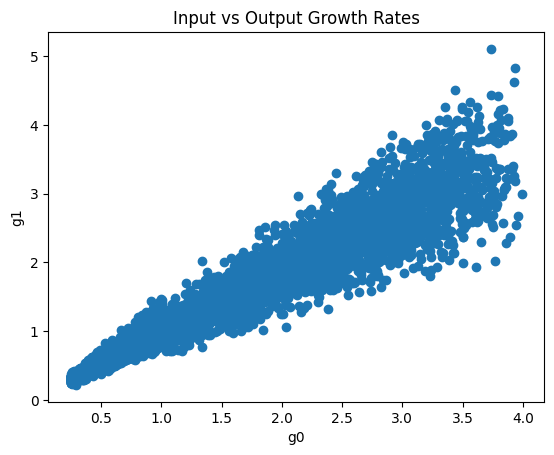

In [16]:
# Visualize how growth rates change with growth iterations
plt.scatter(tmap_annotated.obs['g0'],tmap_annotated.obs['g1'])
plt.xlabel("g0")
plt.ylabel("g1")
plt.title("Input vs Output Growth Rates")
plt.show()

In [17]:
ot_model_strict = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 3,lambda2 = 50) 
tmap_anno_strict = ot_model_strict.compute_transport_map(7,7.5)

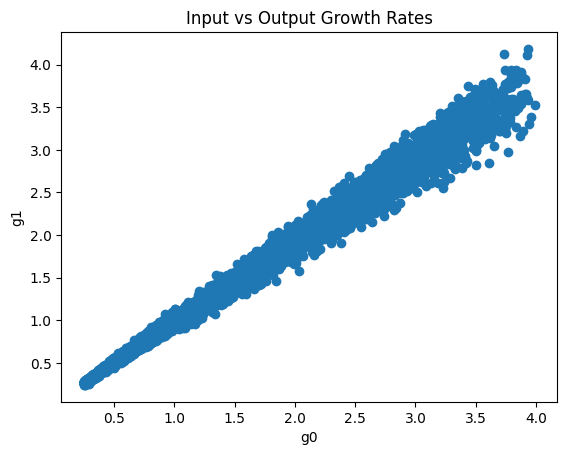

In [18]:
plt.scatter(tmap_anno_strict.obs['g0'],tmap_anno_strict.obs['g1'])
plt.xlabel("g0")
plt.ylabel("g1")
plt.title("Input vs Output Growth Rates")
plt.show()

## Updating growth estimates

In [19]:
ot_model_gr2 = wot.ot.OTModel(adata,epsilon = 0.05, lambda1 = 1,lambda2 = 50,growth_iters=2) 
tmap_anno_gr2 = ot_model_gr2.compute_transport_map(7,7.5)

In [20]:
# row annotations include initial cell growth rates g0, and also g1 and g2
tmap_anno_gr2.obs


,g0,g1,g2
index,,,
D7_Dox_C1_AAACCTGAGGAATCGC-1,1.268895,0.977572,0.771896
D7_Dox_C1_AAACCTGAGTAGATGT-1,2.978660,2.510172,2.130893
D7_Dox_C1_AAACCTGCAACCGCCA-1,1.871918,1.789111,1.692342
D7_Dox_C1_AAACCTGCACTATCTT-1,3.072989,2.790356,2.516849
D7_Dox_C1_AAACCTGCAGCCTGTG-1,1.026225,0.918576,0.815125
...,...,...,...
D7_Dox_C2_TTTGTCAAGTTAGCGG-1,0.338531,0.370486,0.397700
D7_Dox_C2_TTTGTCACAGTGGAGT-1,0.582584,0.609163,0.624180
D7_Dox_C2_TTTGTCAGTAATTGGA-1,0.254926,0.296702,0.334487


(array([   2.,    2.,   23.,   58.,  200.,  624., 1517., 1869.,  726.,
          40.]),
 array([1.4048130237, 1.407357974 , 1.4099029243, 1.4124478747,
        1.414992825 , 1.4175377753, 1.4200827257, 1.422627676 ,
        1.4251726263, 1.4277175767, 1.430262527 ]),
 <BarContainer object of 10 artists>)

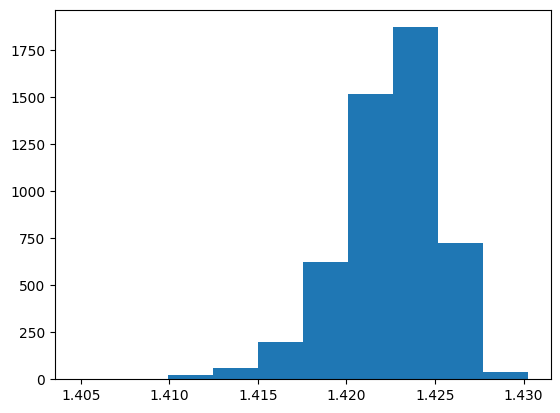

In [21]:
colsums = tmap_anno_gr2.X.sum(axis=0);
plt.hist(colsums)

## Compute all transport maps in batch mode

In [22]:
# Time-consuming, over 30 minutes
ot_model = wot.ot.OTModel(adata, epsilon = 0.05, lambda1 = 1, lambda2 = 50, growth_iters = 3) 
ot_model.compute_all_transport_maps(tmap_out='../data/Time_series_scRNA/wot_data/tmaps/serum')

# we can speed this up by supplying g2 and doing 1 growth iter

# Ancestors, Descendants and Trajectories

In [23]:
import ipywidgets as widgets
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import wot

# input paths
FULL_DS_PATH = '../data/Time_series_scRNA/wot_data/ExprMatrix.h5ad'
CELL_DAYS_PATH = '../data/Time_series_scRNA/wot_data/cell_days.txt'
VAR_DS_PATH = '../data/Time_series_scRNA/wot_data/ExprMatrix.var.genes.h5ad'
TMAP_PATH = '../data/Time_series_scRNA/wot_data/tmaps/serum'
CELL_SETS_PATH = '../data/Time_series_scRNA/wot_data/major_cell_sets.gmt'
COORDS_PATH = '../data/Time_series_scRNA/wot_data/fle_coords.txt'

In [24]:
tmap_model = wot.tmap.TransportMapModel.from_directory(TMAP_PATH)
cell_sets = wot.io.read_sets(CELL_SETS_PATH, as_dict=True)
populations = tmap_model.population_from_cell_sets(cell_sets, at_time=7)

In [25]:
populations

In [26]:
trajectory_ds = tmap_model.trajectories(populations)

In [27]:
# Load embedding coordinates
coord_df = pd.read_csv(COORDS_PATH, sep='\t', index_col=0)
nbins = 500
xrange = coord_df['x'].min(), coord_df['x'].max()
yrange = coord_df['y'].min(), coord_df['y'].max()
coord_df['x'] = np.floor(
    np.interp(coord_df['x'], [xrange[0], xrange[1]], [0, nbins - 1])).astype(int)
coord_df['y'] = np.floor(
    np.interp(coord_df['y'], [yrange[0], yrange[1]], [0, nbins - 1])).astype(int)
trajectory_ds.obs = trajectory_ds.obs.join(coord_df)

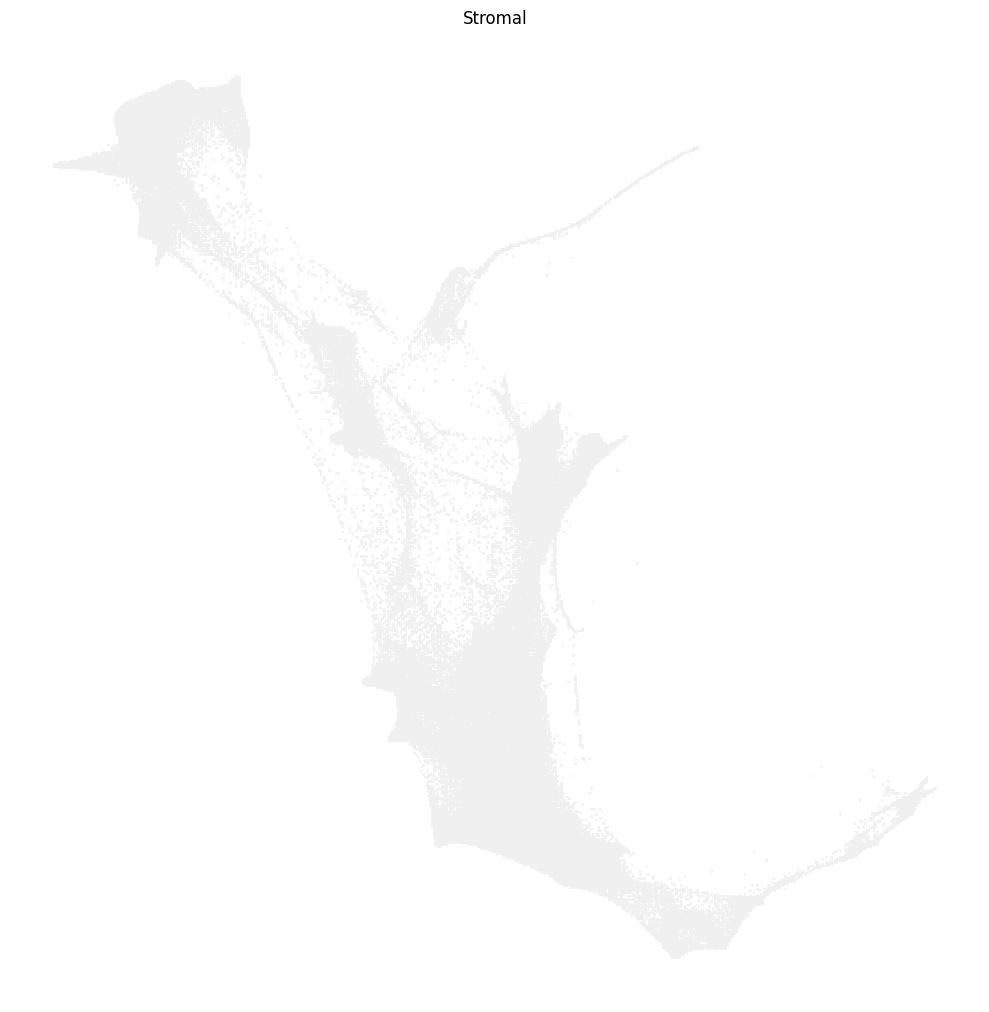

interactive(children=(Dropdown(description='Trajectory:', options=('Stromal', 'Epithelial'), value='Stromal'),…

<function __main__.update_trajectory_vis(name)>

In [28]:
# Visualize trajectories
trajectory_dropdown = widgets.Dropdown(
    options=trajectory_ds.var.index,
    description='Trajectory:'
)

def update_trajectory_vis(name):
    figure = plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.tight_layout()
    plt.title(name)
    plt.scatter(coord_df['x'], coord_df['y'], c='#f0f0f0',
                   s=4, marker=',', edgecolors='none', alpha=0.8)
    binned_df = trajectory_ds.obs.copy()
    binned_df['values'] = trajectory_ds[:, name].X
    binned_df = binned_df.groupby(['x', 'y'], as_index=False).sum()
    plt.scatter(binned_df['x'], binned_df['y'], c=binned_df['values'],
                   s=6, marker=',', edgecolors='none', vmax=binned_df['values'].quantile(0.975))
    plt.colorbar().ax.set_title('Trajectory')

widgets.interact(update_trajectory_vis, name=trajectory_dropdown)

## Expression trends along trajectories

In [29]:
# Load expression data
adata = wot.io.read_dataset(FULL_DS_PATH) 

# Compute trends for all genes
trajectory_trends = wot.tmap.trajectory_trends_from_trajectory(trajectory_ds, adata)

# Save each trajectory in a separate file
for i in range(len(trajectory_trends)):
    wot.io.write_dataset(trajectory_trends[i], '../data/Time_series_scRNA/wot_data/' + trajectory_ds.var.index[i] + '_trends.txt')
    

In [30]:
trajectory_trend_datasets = []
trajectory_names = []

for i in range(trajectory_ds.shape[1]):
    trajectory_names.append(trajectory_ds.var.index[i]) 
    trajectory_trend_datasets.append(wot.io.read_dataset('../data/Time_series_scRNA/wot_data/' + trajectory_ds.var.index[i] + '_trends.txt'))
    

In [31]:
trajectory_dropdown = widgets.SelectMultiple(
    options=trajectory_ds.var.index,
    value=[trajectory_ds.var.index[0]],
    description='Trajectory:'
)

gene_input = widgets.Text(
    placeholder='',
    description='Genes:',
    value='Nanog',
    continuous_update=False
)

def update_trends_vis(selected_trajectories, gene_names):
    gene_names = gene_names.replace(' ', '').split(',')
    
    figure = plt.figure(figsize=(10, 10))
    
    
    for selected_trajectory in selected_trajectories:
        trajectory_index = trajectory_names.index(selected_trajectory)
        mean = trajectory_trend_datasets[trajectory_index]
        mean = mean[:, mean.var.index.str.lower().isin([gene.lower() for gene in gene_names])]
        timepoints = mean.obs.index.values.astype(float)
        mean.obs.index = mean.obs.index.astype('category')
    
        if mean.shape[1] > 0:
            for i in range(mean.shape[1]):  # each gene
                mean_i = mean[:, i].X
                plt.plot(timepoints, mean_i, label=mean.var.index[i] + ', ' + selected_trajectory)
            plt.xlabel("Day")
            plt.ylabel("Expression")
            plt.legend()

widgets.interact(update_trends_vis, selected_trajectories=trajectory_dropdown, gene_names=gene_input)

interactive(children=(SelectMultiple(description='Trajectory:', index=(0,), options=('Stromal', 'Epithelial'),…

<function __main__.update_trends_vis(selected_trajectories, gene_names)>

## Shared Ancestry

In [32]:
adata_var = wot.io.read_dataset(VAR_DS_PATH) 

In [33]:
divergence_df = wot.tmap.trajectory_divergence(adata_var, trajectory_ds, distance_metric='total_variation')

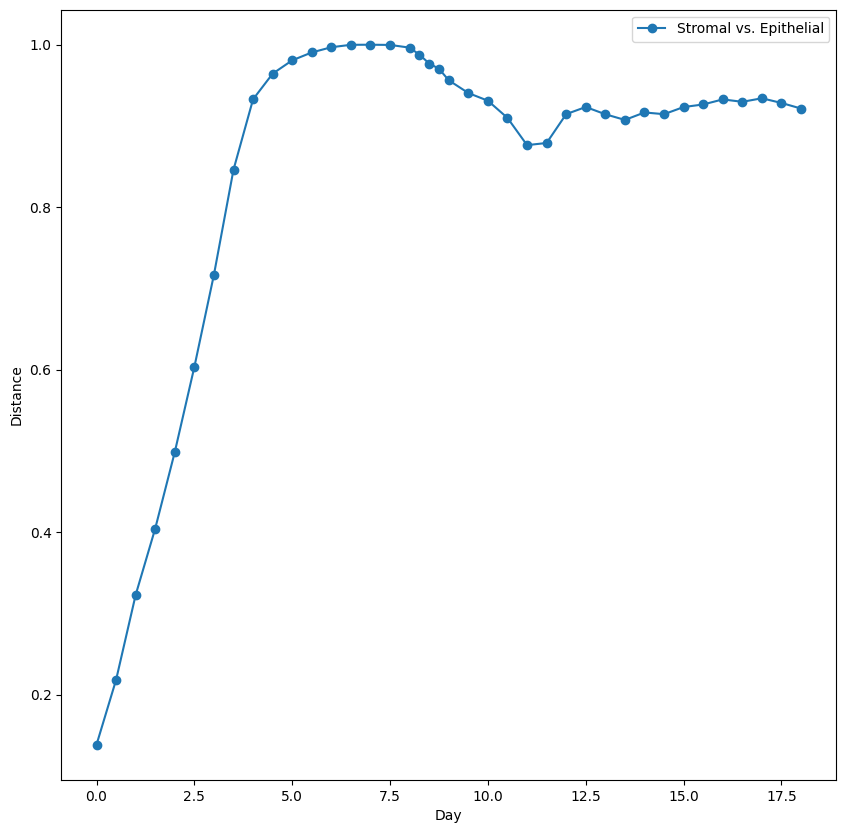

In [34]:
divergence_df['name'] = divergence_df['name1'].str.split('/').str.get(0) + ' vs. ' + divergence_df['name2'].str.split('/').str.get(
        0)
plt.figure(figsize=(10, 10))
plt.xlabel("Day")
plt.ylabel("Distance")
for p, d in divergence_df.groupby('name'):
    plt.plot(d['day2'], d['distance'], '-o', label=p)
plt.legend(loc='best')

# Fate Matrices

## Compute fates

In [35]:
# Load transport map model and cell sets
tmap_model = wot.tmap.TransportMapModel.from_directory('../data/Time_series_scRNA/wot_data/tmaps/serum')
cell_sets = wot.io.read_sets('../data/Time_series_scRNA/wot_data/major_cell_sets.gmt', as_dict=True)

In [36]:
# create indicator vectors for each cell set
target_destinations = tmap_model.population_from_cell_sets(cell_sets, at_time=7)

In [37]:
fate_ds = tmap_model.fates(target_destinations)

## Visualizing fate matrices

In [38]:
import math

fate_dropdown1 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 1:'
)
fate_dropdown2 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 2:',
    value=fate_ds.var.index[1]
)
day_dropdown = widgets.Dropdown(
    options=fate_ds.obs['day'].unique(),
    description='Day',
    value=7
)


def update_fate_vis(name1, name2,day):
    figure = plt.figure(figsize=(10, 10))   

    fate1 = fate_ds[:,name1][fate_ds.obs['day']==day].X.flatten()
    fate2 = fate_ds[:,name2][fate_ds.obs['day']==day].X.flatten()

    Nrows = len(fate1)
    x = np.zeros(Nrows)
    y = np.zeros(Nrows)
    P = np.array([[1,0],[np.cos(2*math.pi/3),math.sin(2*math.pi/3)],[math.cos(4*math.pi/3),math.sin(4*math.pi/3)]])

    for i in range(0,Nrows):
        ff = np.array([fate1[i],fate2[i],1-(fate1[i]+fate2[i])])
        x[i] = (ff @ P)[0]
        y[i] = (ff @ P)[1]

    vx = P[:,0]
    vy = P[:,1]
    t1 = plt.Polygon(P, color=(0,0,0,0.1))
    plt.gca().add_patch(t1)
    
    plt.scatter(x,y)
    plt.scatter(vx,vy)
    #plt.scatter(0,0)
    plt.text(P[0,0]+.1, P[0,1], name1)
    plt.text(P[1,0]-.1, P[1,1]+.1, name2)
    plt.text(P[2,0]-.1, P[2,1]-.2, 'Other')
    plt.axis('equal')
    plt.axis('off')
    #plt.xticks([])
    #plt.yticks([])
    
    plt.title('{} vs. {} on day {}'.format(name1, name2,day))

widgets.interact(update_fate_vis, name1=fate_dropdown1, name2=fate_dropdown2,day=day_dropdown)

interactive(children=(Dropdown(description='Fate 1:', options=('Stromal', 'Epithelial', 'Other'), value='Strom…

<function __main__.update_fate_vis(name1, name2, day)>

In [39]:
fate_dropdown1 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 1:'
)
fate_dropdown2 = widgets.Dropdown(
    options=fate_ds.var.index,
    description='Fate 2:',
    value=fate_ds.var.index[1]
)

def update_fate_vis(name1, name2):
    figure = plt.figure(figsize=(10, 10))
    fate1 = fate_ds[:, name1].X
    fate2 = fate_ds[:, name2].X
    p = np.log(1e-9 + np.divide(fate1, fate2, out=np.zeros_like(fate1), where=fate2 != 0))
    plt.scatter(fate_ds.obs['day'], p, s=4, marker=',')
    plt.xlabel('Day')
    plt.ylabel('Log Odds')
    plt.title('{} vs. {}'.format(name1, name2))

widgets.interact(update_fate_vis, name1=fate_dropdown1, name2=fate_dropdown2)

interactive(children=(Dropdown(description='Fate 1:', options=('Stromal', 'Epithelial', 'Other'), value='Strom…

<function __main__.update_fate_vis(name1, name2)>

# Heatmap

In [40]:
import numpy as np
from matplotlib import pyplot as plt

import wot

In [41]:
tmap_model = wot.tmap.TransportMapModel.from_directory('../data/Time_series_scRNA/wot_data/tmaps/serum')
cell_sets = wot.io.read_sets('../data/Time_series_scRNA/wot_data/major_cell_sets.gmt', as_dict=True)

In [42]:
start_populations = tmap_model.population_from_cell_sets(cell_sets, at_time=0)
end_populations = tmap_model.population_from_cell_sets(cell_sets, at_time=7)

In [43]:
transition_table = tmap_model.transition_table(start_populations, end_populations)

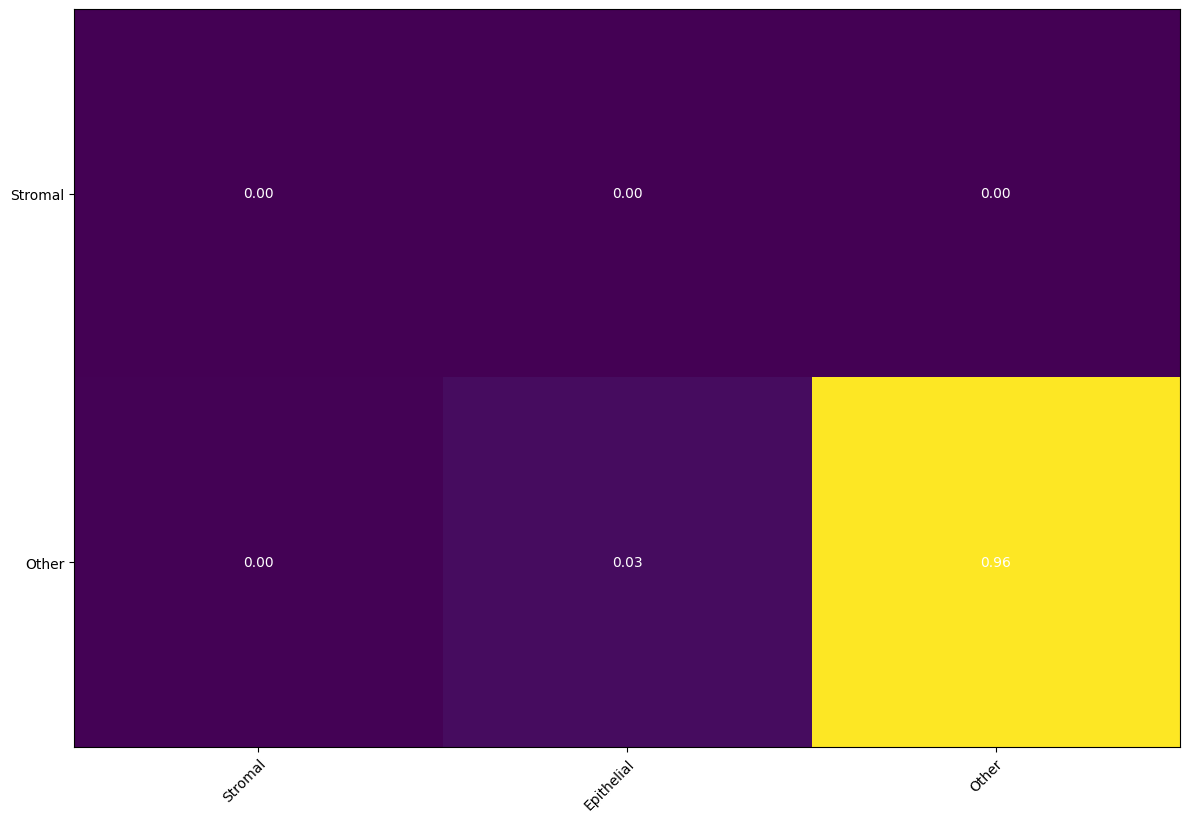

In [44]:
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(transition_table.X)

# We want to show all ticks...
ax.set_xticks(np.arange(len(transition_table.var_names)))
ax.set_yticks(np.arange(len(transition_table.obs_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(transition_table.var_names)
ax.set_yticklabels(transition_table.obs_names)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(transition_table.shape[0]):
    for j in range(transition_table.shape[1]):
        text = ax.text(j, i, '{:.2f}'.format(transition_table.X[i, j]),
                       ha="center", va="center", color="w")
fig.tight_layout()
